In [1]:
import numpy as np
import pandas as pd
import pybroker
from numba import njit
from pybroker import Strategy, StrategyConfig, YFinance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
from numba import njit
import pybroker
import talib
from pybroker import YFinance
pybroker.enable_caches('walkforward_strategy')

In [2]:
yfinance = YFinance()
df_out_sample = yfinance.query(['^GSPC'], start_date='3/1/2010', end_date='3/1/2024')
df_sp = yfinance.query(['^GSPC'], start_date='3/1/2010', end_date='3/1/2024')

Loading bar data...
[*********************100%***********************]  1 of 1 completed
Loaded bar data: 0:00:00 

Loaded cached bar data.



c:\Users\Ochimaru\anaconda3\lib\site-packages\yfinance\utils.py:768: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [10]:
sma_14 = pybroker.indicator('sma_14', lambda data: talib.SMA(data.close, timeperiod=14))
sma_14(df_out_sample)

2010-03-01            NaN
2010-03-02            NaN
2010-03-03            NaN
2010-03-04            NaN
2010-03-05            NaN
                 ...     
2024-02-23    5004.334926
2024-02-26    5013.386335
2024-02-27    5022.239920
2024-02-28    5027.575614
2024-02-29    5034.601318
Length: 3525, dtype: float64

In [11]:
atr_100 = pybroker.indicator('atr_100', lambda data: talib.ATR(data.high,data.low,data.close, timeperiod=100))
atr_100(df_out_sample)

2010-03-01          NaN
2010-03-02          NaN
2010-03-03          NaN
2010-03-04          NaN
2010-03-05          NaN
                ...    
2024-02-23    46.345753
2024-02-26    46.169796
2024-02-27    45.942097
2024-02-28    45.680977
2024-02-29    45.655168
Length: 3525, dtype: float64

In [12]:
sma_atr = pybroker.indicator('sma_atr', lambda data: talib.SMA(data.close, timeperiod=14)+talib.ATR(data.high,data.low,data.close, timeperiod=100)/2)
sma_atr(df_out_sample)

2010-03-01            NaN
2010-03-02            NaN
2010-03-03            NaN
2010-03-04            NaN
2010-03-05            NaN
                 ...     
2024-02-23    5027.507803
2024-02-26    5036.471233
2024-02-27    5045.210969
2024-02-28    5050.416102
2024-02-29    5057.428902
Length: 3525, dtype: float64

In [13]:
from pybroker import IndicatorSet
indicator_set = IndicatorSet()
indicator_set.add(sma_atr)
indicator_set(df_out_sample)

Computing indicators...


  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


,symbol,date,sma_atr
0,^GSPC,2010-03-01,NaN
1,^GSPC,2010-03-02,NaN
2,^GSPC,2010-03-03,NaN
3,^GSPC,2010-03-04,NaN
4,^GSPC,2010-03-05,NaN
...,...,...,...
3520,^GSPC,2024-02-23,5027.507803
3521,^GSPC,2024-02-26,5036.471233
3522,^GSPC,2024-02-27,5045.210969
3523,^GSPC,2024-02-28,5050.416102


In [14]:
import pandas as pd
df_out_sample = df_out_sample.merge(indicator_set(df_out_sample), how='left' ,on=['date','symbol'])
df_out_sample['pct_close'] =  (df_out_sample['close'] - df_out_sample['close'].shift(1)) / df_out_sample['close'].shift(1)
df_sp['pct_close%'] = ((df_sp['close'] / df_sp['close'].shift(1))-1)*100

Computing indicators...


  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [15]:
def train_slr( symbol,train_data, test_data):
    # Train
    # Previous day close prices.
    train_prev_close = train_data['close'].shift(1)
    # Calculate daily returns.
    train_daily_returns = (train_data['close'] - train_prev_close) / train_data['close']
    # Predict next day's return.
    train_data['pred'] = train_daily_returns.shift(-1)
    #train_sma_atr_prev = train_data['sma_atr'].shift(1)
    #train_data['parameter'] = (train_data['sma_atr'] - train_sma_atr_prev) / train_data['sma_atr']
    train_data = train_data.dropna()
    # Train the LinearRegession model to predict the next day's return
    # given the 20-day CMMA.
    X_train = train_data[['sma_atr']]
    y_train = train_data[['pred']]
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Test
    test_prev_close = test_data['close'].shift(1)
    test_daily_returns = (test_data['close'] - test_prev_close) / test_data['close']
    test_data['pred'] = test_daily_returns.shift(-1)
    #test_sma_atr_prev = test_data['sma_atr'].shift(1)
    #test_data['parameter'] = (test_data['sma_atr'] - test_sma_atr_prev) / test_data['sma_atr'] 
    test_data = test_data.dropna()
    X_test = test_data[['sma_atr']]
    y_test = test_data[['pred']]
    # Make predictions from test data.
    y_pred = model.predict(X_test)
    # Print goodness of fit.
    r2 = r2_score(y_test, np.squeeze(y_pred))
    print( symbol,f'R^2={r2}')

    # Return the trained model and columns to use as input data.
    return model

In [16]:
model_slr = pybroker.model('slr', train_slr,indicators=[sma_atr])

In [17]:
def hold_long(ctx):
    if not ctx.long_pos():
        # Buy if the next bar is predicted to have a positive return:
        if ctx.preds('slr')[-1] > 0:
            ctx.buy_shares = ctx.calc_target_shares(1)
    else:
        # Sell if the next bar is predicted to have a negative return:
        if ctx.preds('slr')[-1] < 0:
            ctx.sell_all_shares()

In [18]:
hold = len(df_sp)
def return_sp(ctx):
    if not ctx.long_pos():
        ctx.buy_shares = ctx.calc_target_shares(1)
    else:
        ctx.hold_bar = hold 
        return

Backtesting

In [19]:
import pybroker
from pybroker import Strategy, StrategyConfig, YFinance

pybroker.enable_data_source_cache('my_strategy')

In [20]:
config = StrategyConfig(initial_cash=100000)

In [21]:

strategy_wfa = Strategy(YFinance(), '3/1/2010', '3/1/2024',config)
strategy_sp = Strategy(YFinance(), '3/1/2010', '3/1/2024',config)


In [22]:
strategy_wfa.clear_executions()
strategy_wfa.add_execution(hold_long, ['^GSPC'],models=model_slr)

In [23]:
strategy_sp.clear_executions()
strategy_sp.add_execution(return_sp, ['^GSPC'])

In [24]:
result_wfa = strategy_wfa.walkforward(windows=8,train_size=0.7,lookahead=1,calc_bootstrap=True)



Backtesting: 2010-03-01 00:00:00 to 2024-03-01 00:00:00

Loaded cached bar data.

Loaded cached indicator data.

Train split: 2010-04-06 00:00:00 to 2013-06-03 00:00:00
Loaded cached models.

Test split: 2013-06-04 00:00:00 to 2014-10-03 00:00:00


  0% (0 of 338) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (338 of 338) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2011-08-05 00:00:00 to 2014-10-03 00:00:00
Loaded cached models.

Test split: 2014-10-06 00:00:00 to 2016-02-08 00:00:00


  0% (0 of 338) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 38% (131 of 338) |########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 83% (281 of 338) |##################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (338 of 338) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2012-12-10 00:00:00 to 2016-02-08 00:00:00
Loaded cached models.

Test split: 2016-02-09 00:00:00 to 2017-06-12 00:00:00


  0% (0 of 338) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (338 of 338) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2014-04-15 00:00:00 to 2017-06-12 00:00:00
Loaded cached models.

Test split: 2017-06-13 00:00:00 to 2018-10-12 00:00:00


  0% (0 of 338) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (338 of 338) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2015-08-18 00:00:00 to 2018-10-12 00:00:00
Loaded cached models.

Test split: 2018-10-15 00:00:00 to 2020-02-19 00:00:00


  0% (0 of 338) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 23% (81 of 338) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:00
 68% (231 of 338) |###############       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (338 of 338) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2016-12-19 00:00:00 to 2020-02-19 00:00:00
Loaded cached models.

Test split: 2020-02-20 00:00:00 to 2021-06-22 00:00:00


  0% (0 of 338) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 41% (141 of 338) |#########             | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (338 of 338) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2018-04-25 00:00:00 to 2021-06-22 00:00:00
Loaded cached models.

Test split: 2021-06-23 00:00:00 to 2022-10-24 00:00:00


  0% (0 of 338) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 80% (271 of 338) |#################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (338 of 338) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2019-08-28 00:00:00 to 2022-10-24 00:00:00
Loaded cached models.

Test split: 2022-10-25 00:00:00 to 2024-02-29 00:00:00


  0% (0 of 338) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
100% (338 of 338) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Calculating bootstrap metrics: sample_size=1000, samples=10000...
Calculated bootstrap metrics: 0:00:04 

Finished backtest: 0:00:08


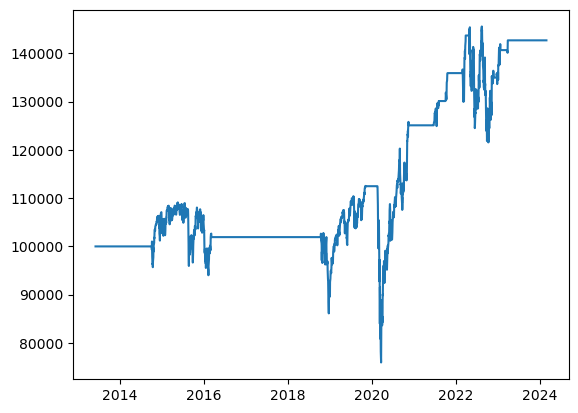

In [25]:
import matplotlib.pyplot as plt

chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result_wfa.portfolio.index,result_wfa.portfolio['market_value'])

In [26]:
result_wfa.positions.head(10)

long_shares  short_shares    close   equity  market_value  \
symbol date                                                                    
^GSPC  2014-10-07           50             0  1935.10  96755.0       96755.0   
       2014-10-08           50             0  1968.89  98444.5       98444.5   
       2014-10-09           50             0  1928.21  96410.5       96410.5   
       2014-10-10           50             0  1906.13  95306.5       95306.5   
       2014-10-13           50             0  1874.74  93737.0       93737.0   
       2014-10-14           50             0  1877.70  93885.0       93885.0   
       2014-10-15           50             0  1862.49  93124.5       93124.5   
       2014-10-16           50             0  1862.76  93138.0       93138.0   
       2014-10-17           50             0  1886.76  94338.0       94338.0   
       2014-10-20           50             0  1904.01  95200.5       95200.5   

                   margin  unrealized_pnl  
symbol date                                
^GSPC  2014-10-07     0.0          -675.5  
       2014-10-08     0.0          1014.0  
       2014-10-09     0.0         -1020.0  
       2014-10-10     0.0         -2124.0  
       2014-10-13     0.0         -3693.5  
       2014-10-14     0.0         -3545.5  
       2014-10-15     0.0         -4306.0  
       2014-10-16     0.0         -4292.5  
       2014-10-17     0.0         -3092.5  
       2014-10-20     0.0         -2230.0

In [27]:
result_wfa.trades


,type,symbol,entry_date,exit_date,entry,exit,shares,pnl,return_pct,agg_pnl,bars,pnl_per_bar,stop,mae,mfe
id,,,,,,,,,,,,,,,
1,long,^GSPC,2014-10-07,2016-03-08,1948.61,1987.16,50,1927.50,1.98,1927.50,356,5.41,None,-138.51,186.11
2,long,^GSPC,2018-10-16,2019-11-08,2790.18,3083.34,36,10553.76,10.51,12481.26,268,39.38,None,-443.60,307.59
3,long,^GSPC,2020-02-21,2020-09-08,3344.60,3354.62,33,330.66,0.30,12811.92,138,2.40,None,-1152.74,243.51
4,long,^GSPC,2020-09-09,2020-10-23,3395.81,3453.45,33,1902.12,1.70,14714.04,32,59.44,None,-186.36,154.04
5,long,^GSPC,2020-10-29,2020-11-17,3300.44,3605.90,34,10385.64,9.26,25099.68,13,798.90,None,-66.50,345.55
6,long,^GSPC,2021-06-24,2021-08-10,4264.12,4437.62,29,5031.50,4.07,30131.18,32,157.23,None,-30.99,176.70
7,long,^GSPC,2021-10-05,2021-10-21,4339.55,4539.17,29,5788.98,4.60,35920.16,12,482.42,None,-49.06,201.32
8,long,^GSPC,2022-03-02,2022-03-29,4362.02,4613.48,31,7795.26,5.76,43715.42,19,410.28,None,-204.15,251.46
9,long,^GSPC,2022-04-28,2022-11-28,4248.54,3984.02,33,-8729.16,-6.23,34986.26,147,-59.38,None,-756.96,76.74


In [28]:
year_out_sample = pd.to_datetime(result_wfa.trades.loc[:,'entry_date']).dt.year
max_year_out_sample = max(year_out_sample)
min_year_out_sample = min(year_out_sample)

In [29]:
result_wfa.metrics_df

,name,value
0,trade_count,11.000000
1,initial_market_value,100000.000000
2,end_market_value,142711.460000
3,total_pnl,42711.460000
4,unrealized_pnl,0.000000
5,total_return_pct,42.711460
6,total_profit,51440.620000
7,total_loss,-8729.160000
8,total_fees,0.000000
9,max_drawdown,-36603.840000


In [30]:
result_sp = strategy_sp.backtest()

Backtesting: 2010-03-01 00:00:00 to 2024-03-01 00:00:00

Loaded cached bar data.

Test split: 2010-03-01 00:00:00 to 2024-02-29 00:00:00


  0% (0 of 3525) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
  4% (141 of 3525) |                     | Elapsed Time: 0:00:00 ETA:   0:00:01
  9% (321 of 3525) |#                    | Elapsed Time: 0:00:00 ETA:   0:00:01
 13% (491 of 3525) |##                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 19% (671 of 3525) |###                  | Elapsed Time: 0:00:00 ETA:   0:00:00
 24% (851 of 3525) |#####                | Elapsed Time: 0:00:00 ETA:   0:00:00
 29% (1031 of 3525) |#####               | Elapsed Time: 0:00:00 ETA:   0:00:00
 34% (1211 of 3525) |######              | Elapsed Time: 0:00:00 ETA:   0:00:00
 39% (1391 of 3525) |#######             | Elapsed Time: 0:00:00 ETA:   0:00:00
 43% (1521 of 3525) |########            | Elapsed Time: 0:00:00 ETA:   0:00:00
 48% (1701 of 3525) |#########           | Elapsed Time: 0:00:00 ETA:   0:00:00
 53% (1881 of 3525) |##########          | Elapsed Time: 0:00:00 ETA:   0:00:00
 57% (2011 of 3525) |###########        


Finished backtest: 0:00:01


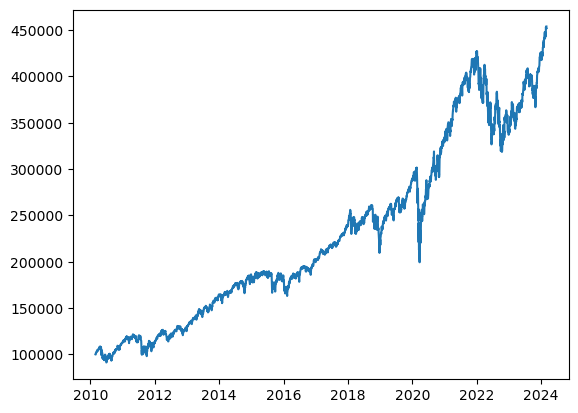

In [31]:
chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result_sp.portfolio.index,result_sp.portfolio['market_value'])

In [32]:
result_sp.metrics_df

,name,value
0,trade_count,0.000000
1,initial_market_value,100000.000000
2,end_market_value,453889.810000
3,total_pnl,0.000000
4,unrealized_pnl,353889.810000
5,total_return_pct,0.000000
6,total_profit,0.000000
7,total_loss,0.000000
8,total_fees,0.000000
9,max_drawdown,-108538.180000


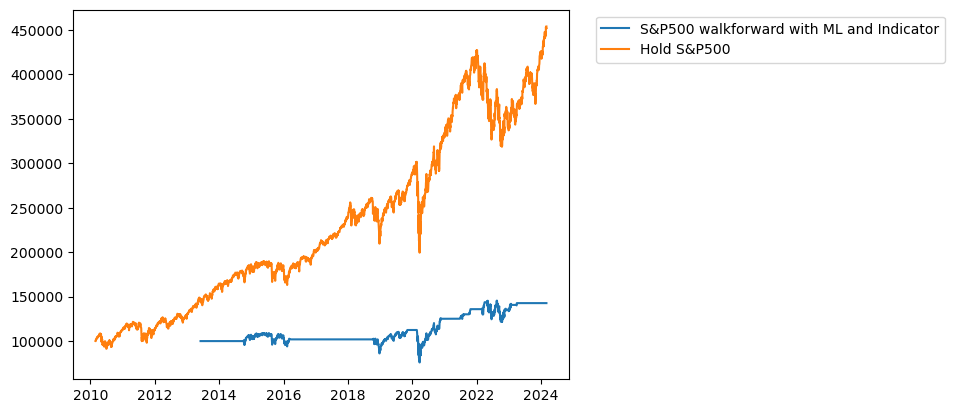

In [33]:
#compare 3 graph with in sample data , out sample data , s&p500
chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result_wfa.portfolio.index,result_wfa.portfolio['market_value'], label = 'S&P500 walkforward with ML and Indicator')
chart.plot(result_sp.portfolio.index,result_sp.portfolio['market_value'] , label = 'Hold S&P500')
plt.legend(bbox_to_anchor=(1.04,1))

In [34]:
sd_out_sample = df_out_sample['pct_close'].std()
print(f'Standard Deviation Out Sample: {sd_out_sample} %')
#Assuming that there are 252 trading days
Annualized_Volatility_out_sample = sd_out_sample * np.sqrt(252)
print(f'Annualized Volatility Out Sample : {Annualized_Volatility_out_sample} %')
Annualized_Return_out_sample  =((result_wfa.metrics_df.loc[2,'value']-result_wfa.metrics_df.loc[1,'value'])/result_wfa.metrics_df.loc[1,'value'])/(max_year_out_sample-min_year_out_sample)
print(f'Annualized_Return_out_sample : {Annualized_Return_out_sample} %') 
sharpe_ratio_out_sample = Annualized_Return_out_sample/Annualized_Volatility_out_sample
print(f'Sharpe_ratio_out_sample : {sharpe_ratio_out_sample} %')

Standard Deviation Out Sample: 0.011002992926361525 %
Annualized Volatility Out Sample : 0.17466709776333253 %
Annualized_Return_out_sample : 0.04745717777777777 %
Sharpe_ratio_out_sample : 0.2717007289036227 %
